In [1]:
##############################  All necessary imports  #########################
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import *
%matplotlib inline
plt.style.use('ggplot')

# Find the lowest eigen value of the matrix M below using VQE
### Contents:
1. Exact solution using Numpy linalg module
2. Pauli gate decomposition and its verification
3. Expeectation value calculation on quantum computer
4. Measurement and basis transformation
5. Variational Ansatz: 2 trial wave functions
6. Exploration of $\theta$ for $R_{x}(\theta)$ with Ansatz-1
7. VQE with scipy optimizer using Ansatz-1
8. VQE with scipy optimizer using Ansatz-2



$$ 
M = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} 
$$

We can evaluate the lowest eigen values by using Numpy library 

# 1. Exact solution with Numpy linalg module

In [2]:
M = np.array([[1,0,0,0],
              [0,0,-1,0],
              [0,-1,0,0],
              [0,0,0,1]])

eig_vals,eig_vecs = np.linalg.eig(M)


print('Our given matrix is:\n\n',M)
print('\nEigen values are:',eig_vals)
print('\nLowest eigen value is:',round(eig_vals.min()))

Our given matrix is:

 [[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]

Eigen values are: [ 1. -1.  1.  1.]

Lowest eigen value is: -1.0


# 2. Solving this using VQE requires Pauli gate decomposition

Decomposition of $M$ matrix into a sum of 2-qubit operators,

\begin{align}
H = a X_1 \otimes X_2+b Y_1 \otimes Y_2+ c Z_1 \otimes Z_2+d I_1 \otimes I_2
\end{align}

where the subscripts ${1,2}$ denote the first and second qubit on which the operator acts on, and $\otimes$ indicates the tensor product, and $a,b,c,d$ are the coefficients. Pauli matrices $X,Y,Z$ are,


\begin{align}
X = \begin{bmatrix}0 &1  \\ 1 &0 \end{bmatrix}, &  &
Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, & &
Z = \begin{bmatrix} 1 &0  \\ 0 &-1 \end{bmatrix}. 
\end{align}



Here $XX$,$YY$,$ZZ$ and $II$ are,


\begin{align}
XX = \begin{bmatrix}0&0&0&1\\0&0&1&0\\0&1&0&0\\1&0&0&0 \end{bmatrix}, &  &
YY = \begin{bmatrix}0&0&0&-1\\0&0&1&0\\0&1&0&0\\-1&0&0&0 \end{bmatrix}, &  &
ZZ = \begin{bmatrix}1&0&0&0\\0&-1&0&0\\0&0&-1&0\\0&0&0&1 \end{bmatrix}, &  &
II = \begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1 \end{bmatrix}, 
\end{align}


### Respective coefficients can be found by solving linear equation analytically,
\begin{align}
a=-0.5,b=-0.5,c=0.5,d=0.5
\end{align}

  $M$ in 2 qubit pauli operator decomposed format is

\begin{align}
M = \frac{1}{2}\left(- X_1 \otimes X_2 - Y_1 \otimes Y_2+ Z_1 \otimes Z_2 + I_1 \otimes I_2 \right),
\end{align}
 

### Verification of pauli decomposition

In [3]:
############   checking the result of Pauli decomposition  #################

X = np.array([[0,1],[1,0]])       # pauli's sigma-x matrix
Y = np.array([[0, -1j],[1j, 0]])  # pauli's sigma-y matrix
Z = np.array([[1,0],[0,-1]])      # pauli's sigma-z matrix
I = np.array([[1,0],[0,1]])       # 2X2 Identity matrix



XX = np.kron(X,X)       
YY = np.kron(Y,Y)
ZZ = np.kron(Z,Z)
II = np.kron(I,I)

a,b,c,d = -0.5,-0.5,0.5,0.5
M1 = (a*XX) + (b*YY) + (c*ZZ) + (d*II)
print('M1 matrix is\n\n',M1.astype(int),'\n\nPauli decomposition verified:',np.array_equal(M,M1))

M1 matrix is

 [[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]] 

Pauli decomposition verified: True


# 3. Expectation value calculation on Quantum computer

A general 2 qubit state can be represented as,

\begin{align}  
\left|\psi\right> = \alpha_{00}\left|00\right> + \alpha_{01}\left|01\right> + \alpha_{10}\left|10\right> + \alpha_{11}\left|11\right>
\end{align}  

Expectation value of the above operator M on $\left< \psi\right>$,
\begin{align}      
E = \left< \psi\right| M \left| \psi\right>  
\end{align}

Now if we want to measure expectation value of any operator (say, $Z_{1} \otimes Z_{2}$) for the above state on computational basis, it follows

\begin{align}
\left< \psi\right|Z_{1} \otimes Z_{2}\left| \psi\right> = \alpha_{00}^2 - \alpha_{01}^2 - \alpha_{10}^2 + \alpha_{11}^2  = (\alpha_{00}^2 + \alpha_{11}^2) - (\alpha_{01}^2 + \alpha_{10}^2) \\ = \text{(prob(00) + prob(11)) - (prob(01) + prob(10))} \\ = \frac{\text{(count(00)+count(11))-(count(01)+count(10))}}{\text{shots}}
\end{align}

Hence, we'll also measure other 2 qubit operators $X_{1} \otimes X_{2}$ and $Y_{1} \otimes Y_{2}$ in the computational basis.

# 4. Measurement and Basis Transformation

We have to measure every observables in their respective basis. 

1. The first term in the hamiltonian $X_{1} \otimes X_{2}$ is in the hadamard basis. Since

\begin{align}
X\left| + \right> &= \left|+ \right> & X\left| - \right> = -\left|- \right>
\end{align}
where
\begin{align}
\left|+\right> &= \frac{1}{\sqrt2}\left(\left|0\right> + \left| 1 \right> \right) & \left|-\right> &= \frac{1}{\sqrt2}\left(\left|0\right> - \left| 1 \right> \right)
\end{align}



So we need to apply some basis transformation such that $\left| + \right>$ goes to $\left| 0 \right>$ and $\left| - \right>$ goes to $\left| 1 \right>$. Such a gate is hadamard $H$ gate.



\begin{align}
H\left| + \right> &= \left|0\right> & H\left| - \right> = \left|1\right>
\end{align}

So, we will apply hadamard gate on both qubits before measurement. We could have used $R_{y}(-\pi/2)$ or $U_{3}$ on both qubits.

so,
\begin{align}
X_{1} \otimes X_{2} &= \left(H_1 \otimes H_2 \right)^\dagger Z_1 \otimes Z_2  \left(H_1 \otimes H_2 \right),
\end{align}



2. The 2nd term $Y_{1} \otimes Y_{2}$ is also not in the $Z$ basis. $Y$ has two eigen vectors,
\begin{align}
\left| +i \right> &= \frac{1}{\sqrt2}\left(\left|0\right> + i\left| 1 \right> \right) & \left| -i \right> &= \frac{1}{\sqrt2}\left(\left|0\right> - i\left| 1 \right> \right)
\end{align}

In this case our transformation will be $HS^\dagger$ , which will be applied to every qubit before measurement as, 
\begin{align}
HS^\dagger\left| +i \right> &= \left|0\right> & HS^\dagger\left| -i \right> = \left|1\right>
\end{align}

We could have used $R_{x}(\pi/2)$ or $U_{3}(\pi/2,0,\pi/2)$ gate on each qubits. So,

\begin{align}
Y_{1} \otimes Y_{2} &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)^\dagger Z_1 \otimes Z_2  \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right),
\end{align}

where,
\begin{align}
S^\dagger = \begin{bmatrix}1 & 0 \\ 0 & -i\end{bmatrix} & &
H = \frac{1}{\sqrt2} \begin{bmatrix}1 & 1 \\ 1 & -1\end{bmatrix}
\end{align}



3. $Z_{1} \otimes Z_{2}$ is already in $Z$ basis, so we dont need to do any basis transformation. 


4. The 4th term $I_{1} \otimes I_{2}$ is just a constant. No measurement is required.


These identities allow us to write our original matrix $M$ as the sum of operators

 
\begin{align}
M = -\frac{1}{2}\left(H_1 \otimes H_2 \right)^\dagger \left( Z_1 \otimes Z_2 \right)  \left(H_1 \otimes H_2 \right)
- \frac{1}{2}\left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)^\dagger \left( Z_1 \otimes Z_2 \right)  \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right) + \frac{1}{2}\left( Z_1 \otimes Z_2 \right) + \frac{1}{2}\left( I_1 \otimes I_2 \right).
\end{align}


The expectation value of the above matrix on the state $| \psi \rangle$ is given as


\begin{align}
\left< \psi \right| M \left| \psi \right> = -\frac{1}{2} \left< \phi_1 \right| \left( Z_1 \otimes Z_2 \right)\left| \phi_1 \right>    - \frac{1}{2} \left< \phi_2 \right|\left( Z_1 \otimes Z_2 \right) \left| \phi_2 \right>  +\frac{1}{2}\langle \psi|\left( Z_1 \otimes Z_2 \right)\left| \psi \right>  + \frac{1}{2}  
\end{align}


where new states $\left| \phi_1 \right>$ and $\left| \phi_2 \right>$ are

  
\begin{align}  
\left| \phi_1 \right> &=  \left(H_1 \otimes H_2 \right) \left|\psi \right>, \\  
\left| \phi_2 \right> &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right) \left|\psi \right>  
\end{align}  


In [4]:
## All the necessary functions for the algorithm are written here ##

def XX(theta):
    """
    Gives expectation value of XX
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of XX
    """
    circuit = ansatz(theta)
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    ###########  Transformation on XX ###########

    circuit.h(q[0])              #circuit.ry(-np.pi/2, q[0])
    circuit.h(q[1])              #circuit.ry(-np.pi/2, q[1])

    ############  XX measurement  ##############
    circuit.measure(q,c)
    exp_XX = measurement(circuit)
    return exp_XX
    
def YY(theta):
    """
    Gives expectation value of YY
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of YY
    """
    circuit = ansatz(theta)
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    ########### Transformation on YY #########

    circuit.sdg(q[0])           #circuit.rx(np.pi/2, q[0])
    circuit.h(q[0])             #circuit.rx(np.pi/2, q[1])
    circuit.sdg(q[1])
    circuit.h(q[1])

    ############ YY Measurement ###########  
    circuit.measure(q,c)
    exp_YY = measurement(circuit)
    return exp_YY

def ZZ(theta):
    """
    Gives expectation value of ZZ
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of ZZ
    """
    circuit = ansatz(theta)
    q = circuit.qregs[0]
    c = circuit.cregs[0]

    ###########  ZZ measurement ###############  
    circuit.measure(q,c)
    exp_ZZ = measurement(circuit)
    return exp_ZZ

def vqe(theta):    #------------------- creates ansatz measures and performs addition to get the eigen value
    """
    Contains the complete Hamiltonian
    :param theta: angle is radian
    :return: expectation value of whole hamiltonian
    """                                                                # H = aXX + bYY + cZZ + dII
    E = (-0.5*XX(theta)) + (-0.5*YY(theta)) + (0.5*ZZ(theta)) + 0.5    #Hamiltonian  with a,b,c,d
    return E

def key_check(my_dict: dict, my_key: str):
    """
    If key is missing returns 0
    otherwise the corresponding value.
    :param my_dict: the dictionary
    :param my_key: key (string)
    :return: 0 or value corresponding to key
    """
    response = 0
    if my_key in my_dict:
        response = my_dict[my_key]
    return response

    
def measurement(circuit):  # ------------------ Takes a quantum circuit and perform measurement
    """
    Takes the quantum circuit as
    input to perform measurement
    :param circuit: quantumm circuit
    :return: expectation value
    """
    shots =1024
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    n00 = key_check(counts,'00')
    n01 = key_check(counts,'01')
    n10 = key_check(counts,'10')
    n11 = key_check(counts,'11')
    expectation_value = ((n00+n11)-(n01+n10))/shots 
    return expectation_value

# 5. Variational Ansatz : Trial wave function

According to the theory of Variational methods for Quantum mechanics, to measure the expectation value of $M$ we need a trial wave function or ansatz $\left| \psi(\theta) \right>$ .

\begin{align}      
E(\theta) = \left< \psi(\theta)\right| M \left| \psi(\theta) \right>  
\end{align}

Here we have discussed the solution with two ansatz.

### Ansatz 1: Given in the question of Task 4 with 1 parametric $R_{x}(\theta)$ gate
\begin{align}
\left| \psi (\theta) \right>_{1} = (R_{x}(\theta) \otimes I)CX(H \otimes I) \left| 00 \right>.
\end{align}

### Ansatz 2: Circuit with 6 parametric $R_{y}(\theta)$ gates
\begin{align}
\left| \psi (\theta) \right>_{2} = CX(R_{y}(\theta_{0}) \otimes R_{y}(\theta_{1}))CX(R_{y}(\theta_{0}) \otimes R_{y}(\theta_{1}))CX(R_{y}(\theta_{0}) \otimes R_{y}(\theta_{1})) \left| 00 \right>.
\end{align}

![alt text](rsz_ansatzcollage.png "Ansatz collection")




# Attention! Mechanism of $ansatz(\theta)$ function $\left| \psi (\theta) \right>$
A single function is presented below for both ansatz. The working mechanism is little different. The $theta-\theta$ in function $ansatz(theta)$ is a list or array with one or two elements. When $theta-\theta$ with one-parameter(list or array with one element) is passed into $ansatz(theta)$, it automatically starts using Ansatz-1, as there is only one parametric angle is Ansatz-1. Similarly if we pass $theta-\theta$ list or array with 2 parameters (list or array with 2 elements), the $ansatz(theta)$ function will use Ansatz-2.

In [5]:
def ansatz(theta):
    """
    Creates ANSATZ with an 
    angle taking as parameter &
    returns a quantum circuit.
    :param theta: angle in radian
    :return: quantum circuit
    """
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q,c)
    if len(theta) ==1:   #--------------- Ansatz 1
        circuit.h(q[0])
        circuit.cx(q[0],q[1])
        circuit.rx(theta[0],q[0])
        return circuit
    elif len(theta)==2:  #--------------- Ansatz 2
        for i in range(3):  #----------------circuit depth
            circuit.cx(q[0],q[1])
            circuit.ry(theta[0],q[0])
            circuit.ry(theta[1],q[1])
        return circuit

### As Ansatz-1 contains one parametric angle, it is easier to search over all spaces from 0 to $2\pi$ , but for Ansatz-2 there are 6 parametric gates (taking depth of the circut into account), which is little difficult for searching. Hence, searching is performed with Ansatz-1. Later on there are solutions using Scipy optimizers with Ansatz-1 and Ansatz-2 both.

# 6. $\theta$ exploration of $R_{x}(\theta)$ with Ansatz 1

Ansatz 1 uses one parametric gate $R_{x}(\theta)$. Here $N$ equispaced angles are introduced between 0 to $2\pi$ and for each angle (theta) expectation value is calculated using for loop. No optimizer is used here.

Search in progress... Please wait!

 
 
Minimum energy eigen value is: -1.0
Angle corresponds to this energy is 3.15421 radian



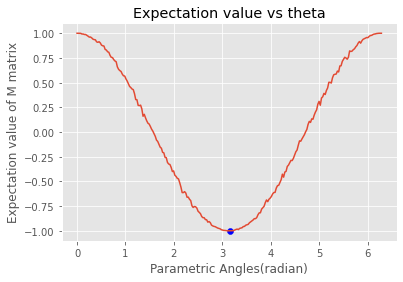

In [6]:
#################   Exploration   ###############
N =  250
all_angles = np.linspace(0,2*np.pi,N)
angles = []        #--------------------------------- list for storing Parametric angles
energies = []      #--------------------------------- list for storing eigen values
print("Search in progress... Please wait!")

for theta in all_angles.reshape(N,1):
    E = vqe(theta)
    angles.append(theta)
    energies.append(E)
    #print('Parametric angle is {} and energy eigen value is {} \n'.format(round(float(theta),3),E))


print('\n \n \nMinimum energy eigen value is:',min(energies))
print('Angle corresponds to this energy is {} radian\n'.format(round(all_angles[np.argmin(energies)],5)))

plt.plot(angles,energies)
plt.scatter(all_angles[np.argmin(energies)],min(energies),color='blue')
plt.title('Expectation value vs theta', color='k')
plt.xlabel('Parametric Angles(radian)')
plt.ylabel('Expectation value of M matrix')
plt.show()

### In VQE state preparation and measurement is carried by Quantum module (QPU) and optimization of the angle of the parametric gates are done by classical optimizers (CPU).

# 7. Finding solution of VQE with Ansatz 1 using Scipy optimizer
One parametric angle is passed within the $theta$.Function $ansatz(theta)$ will use Ansatz-1

In [7]:
###########  VQE by Scipy Optimizers with Ansatz 1 ##############

theta = [2] #------------- One parameter in the list


result = minimize(vqe, theta, method="Powell")  # Powell, COBYLA, Nelder-Mead and others can be used
print(result.message)
print('\nLowest eigen value of M using VQE with ansatz_1 is {}'.format(result.fun))
print('Parametric angle is {} radian.'.format(round(float(result.x),5)))
print('Success Status:',result.success)

Optimization terminated successfully.

Lowest eigen value of M using VQE with ansatz_1 is -1.0
Parametric angle is 3.13717 radian.
Success Status: True


# 8. Finding solution of VQE with Ansatz 2 using Scipy optimizer
Two parametric angles are passed within the $theta$. Function $ansatz(theta)$ will use Ansatz-2. These 2 angles will be used in 6 parametric gates as the depth is 3.

In [8]:
###########  VQE by Scipy Optimizers with Ansatz 2  ##############

theta = [2,2]  #---------------------- 2 parameters in the list


result = minimize(vqe, theta, method="Powell")  # Powell, Nelder-Mead, COBYLA  and others can be used
print(result.message)
print('\nLowest eigen value of M using VQE with ansatz_2 is {}'.format(result.fun))
print('Success Status:',result.success)

Optimization terminated successfully.

Lowest eigen value of M using VQE with ansatz_2 is -1.0
Success Status: True
